# ENSO amplitude change in the LongRunMIP
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu
This notebook plots changes in ENSO amplitude from the LongRunMIP, for a supplemental figure for Callahan et al., "Robust long-term changes in ENSO amplitude...". Specifically, it tests whether adaptively defining the "transient period" using the rate of GMST change in each model changes our results.

#### Mechanics
Read in dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.io import loadmat
from matplotlib.patches import Polygon
from scipy import signal
from scipy import stats

Set data locations

In [3]:
loc_nino34 = "../Data/ENSO_Indices/"
loc_gmst = "../Data/GMST/"

Models, experiments, and colors

In [4]:
modelnames_fig = ['CCSM3 abrupt 2x','CCSM3 abrupt 4x','CCSM3 abrupt 8x', \
    'CESM1.0.4 abrupt 2x','CESM1.0.4 abrupt 4x','CESM1.0.4 abrupt 8x', 'CNRM-CM6.1 abrupt4x', \
    'GFDL-CM3 1pct 2x','GFDL-ESM2M 1pct 2x','GISS-E2-R 1pct 4x', \
    'GISS-E2-R abrupt 4x','HadCM3L abrupt 2x','HadCM3L abrupt 4x', \
    'HadCM3L abrupt 6x','HadCM3L abrupt 8x','IPSL-CM5A-LR abrupt 4x', \
    'MIROC3.2 1pct 2x','MIROC3.2 1pct 4x','MPIESM-1.2 abrupt 2x', \
    'MPIESM-1.2 abrupt 4x','MPIESM-1.2 abrupt 8x']

modelnames_file = ['CCSM3_abrupt2x','CCSM3_abrupt4x','CCSM3_abrupt8x', \
    'CESM104_abrupt2x','CESM104_abrupt4x','CESM104_abrupt8x', \
    'CNRMCM61_abrupt4x','GFDLCM3_1pct2x','GFDLESM2M_1pct2x','GISSE2R_1pct4x', \
    'GISSE2R_abrupt4x','HadCM3L_abrupt2x','HadCM3L_abrupt4x', \
    'HadCM3L_abrupt6x','HadCM3L_abrupt8x','IPSLCM5A_abrupt4x', \
    'MIROC32_1pct2x','MIROC32_1pct4x','MPIESM12_abrupt2x', \
    'MPIESM12_abrupt4x','MPIESM12_abrupt8x']

ex1 = ['CCSM3_abrupt2x','CCSM3_abrupt4x','CCSM3_abrupt8x', \
    'CESM1-0-4_abrupt2x','CESM1-0-4_abrupt4x','CESM1-0-4_abrupt8x', \
    'GFDL-CM3_1pct2x','GFDL-ESM-2M_1pct2x','GISS-E2R_1pct4x', \
    'GISS-E2R_abrupt4x','HadCM3L_abrupt2x','HadCM3L_abrupt4x', \
    'HadCM3L_abrupt6x','HadCM3L_abrupt8x','IPSL_abrupt4x', \
    'MIROC_1pct2x','MIROC_1pct4x','MPI-ESM-12_abrupt2x', \
    'MPI-ESM-12_abrupt4x','MPI-ESM-12_abrupt8x']

runtype = ['abrupt','abrupt','abrupt','abrupt','abrupt','abrupt','lin','lin','lin', \
            'abrupt','abrupt','abrupt','abrupt','abrupt','abrupt', \
            'lin','lin','abrupt','abrupt','abrupt','abrupt']

colors = [[0,238,0],[0,238,0],[0,238,0], \
          [34,139,34],[34,139,34],[34,139,34],[135,206,255],[16,78,139],[30,144,255], \
          [255,110,180],[255,110,180],[255,0,0],[255,0,0],[255,0,0],[255,0,0], \
          [255,193,37],[122,55,139],[122,55,139],[153,153,153],[153,153,153],[153,153,153]]

colors_double = []
for i in np.arange(0,len(colors),1):
    colors_double.append(colors[i])
    colors_double.append(colors[i])

Function for setting boxplot color

In [7]:
def set_boxplot_col(b,n,c,c_double,lw,median):
    
    # This function sets the colors of a given boxplot b
    # It auto-sets the colors of the boxes, whiskers, caps, and fliers to c[m]
    # and it sets the colors of the medians if median=True
    # n is the number of instances of the boxplot and lw is the desired
    # linewidth
    # c should be a vector of colors
    
    for m in range(0,n*2,1):
        if m < n:
            b["boxes"][m].set(color=c[m],linewidth=lw)
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)
            #b["fliers"][m].set(markerfacecolor=c[m],markeredgecolor=c[m])
            if median==True:
                b["medians"][m].set(color=c[m],linewidth=lw)
        else:
            b["whiskers"][m].set(color=c_double[m],linewidth=lw)
            b["caps"][m].set(color=c_double[m],linewidth=lw)

#### Analysis

Create empty array, then add new amplitude change arrays as we go through the simulations

First set running mean length, in years

In [9]:
rm_yrs = 100
rm_length = rm_yrs*12
gmst_smooth_yrs = 20

In [10]:
transient_change = np.zeros(len(modelnames_file))
equilibrium_change = []
pvals = np.zeros(len(modelnames_file))

for i in np.arange(0,len(modelnames_file),1):
            
    model, exp = modelnames_file[i].split("_")
    print(modelnames_file[i])
    
    nino34_ctrl_anom = xr.DataArray(xr.open_dataset(loc_nino34+"nino34_"+model+"_control_anom_detrend2.nc").data_vars["nino34"])
    nino34_forced_anom = xr.DataArray(xr.open_dataset(loc_nino34+"nino34_"+model+"_"+exp+"_anom_detrend2.nc").data_vars["nino34"])
    
    std_f1 = pd.Series(nino34_forced_anom).rolling(rm_length,center=False).std().values
    std_c1 = pd.Series(nino34_ctrl_anom).rolling(rm_length,center=False).std().values
    
    std_c = std_c1[~np.isnan(std_c1)]
    std_f = std_f1[~np.isnan(std_f1)]
    
    baseline1 = np.mean(std_c)
    baseline2 = np.std(nino34_ctrl_anom)
    
    amp_change = ((std_f - baseline1)/baseline1)*100
    amp_cdist = ((std_c - baseline1)/baseline1)*100
    
    # Split amplitude change into transient and equilibrium
    # but first load GMST to help with this
    
    # GMST
    gmst_change = xr.DataArray(xr.open_dataset(loc_gmst+"GMST_anom_"+model+"_"+exp+".nc").data_vars["gmst"])
    #gmst_change = gmst_f - np.mean(gmst_c)
    gmst_anom1 = pd.Series(gmst_change).rolling(12*gmst_smooth_yrs,center=False).mean().values
    gmst_anom = gmst_anom1[~np.isnan(gmst_anom1)]
    
    # Calculate percentile amount of GMST change
    percent = 75
    gmst_final = np.mean(gmst_anom[(gmst_anom.shape[0])-(100*12):])
    transient_boundary = list(gmst_anom > (percent/100.0)*gmst_final).index(True)
    
    transient_change[i] = np.mean(amp_change[0:transient_boundary])
    amp_change_eq = amp_change[transient_boundary:]
    equilibrium_change.append(amp_change_eq)

CCSM3_abrupt2x
CCSM3_abrupt4x
CCSM3_abrupt8x
CESM104_abrupt2x
CESM104_abrupt4x
CESM104_abrupt8x
CNRMCM61_abrupt4x
GFDLCM3_1pct2x
GFDLESM2M_1pct2x
GISSE2R_1pct4x
GISSE2R_abrupt4x
HadCM3L_abrupt2x
HadCM3L_abrupt4x
HadCM3L_abrupt6x
HadCM3L_abrupt8x
IPSLCM5A_abrupt4x
MIROC32_1pct2x
MIROC32_1pct4x
MPIESM12_abrupt2x
MPIESM12_abrupt4x
MPIESM12_abrupt8x


#### Plot
Boxplot of transient and equilibrium amplitude changes

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


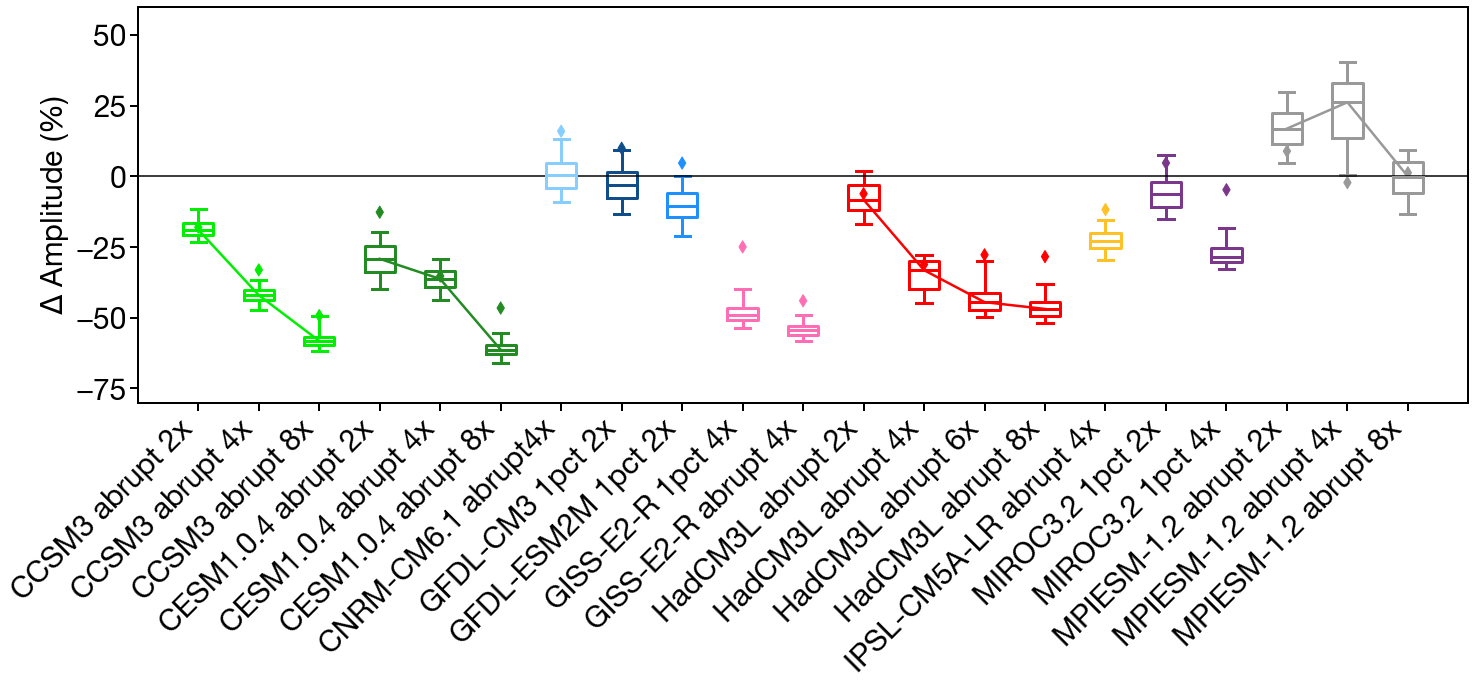

In [12]:
eq = equilibrium_change

fig = plt.figure(figsize=(24,10))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 30.0
rcParams["axes.linewidth"] = 2
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 2

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.15,right=0.92,top=0.95,bottom=0.4,wspace=0.2,hspace=0.28)

ax = plt.subplot(gs1[0,0])

b1 = plt.boxplot(equilibrium_change,whis=[5,95],sym="")
set_boxplot_col(b1,21,np.array(colors)/255.,np.array(colors_double)/255.,3,True)

plt.scatter(np.arange(1,22,1),transient_change,c=np.array(colors)/255.,s=75,marker="d")
plt.plot([1,2,3],[np.median(eq[0]),np.median(eq[1]),np.median(eq[2])],linewidth=2.5,color=np.array(colors[0])/255.)
plt.plot([4,5,6],[np.median(eq[3]),np.median(eq[4]),np.median(eq[5])],linewidth=2.5,color=np.array(colors[3])/255.)
plt.plot([12,13,14,15],[np.median(eq[11]),np.median(eq[12]),np.median(eq[13]),np.median(eq[14])],linewidth=2.5,color=np.array(colors[12])/255.)
plt.plot([19,20,21],[np.median(eq[18]),np.median(eq[19]),np.median(eq[20])],linewidth=2.5,color=np.array(colors[18])/255.)

for i in np.arange(0,len(ex1)):
    if pvals[i] >= 0.05:
        plt.scatter(i+1,-75,color="white",edgecolors=[0.5,0.5,0.5],s=100)
        
plt.axhline(y=0,linewidth=1.5,color="k",linestyle="-")

plt.xticks(np.arange(1,22,1),modelnames_fig,rotation=45,horizontalalignment="right")

plt.xlim([0,22])
plt.ylim([-80,60])
plt.ylabel("$\Delta$ Amplitude (%)")


plt.savefig("../Figures/FigS3_Transient_"+str(percent)+"pct_Warming.pdf")
plt.show()